In [1]:
import pandas as pd
import numpy as np
from torch import nn
import torch
from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt

# Chem 277B : HW7 - Deep Learning and Regularization #

## 1. Bias-variance tradeoff ##

We will use the MNIST data set to train, validate, and test using a deep learning
network. The input representation will be raw image vector for each number comprised of 32x32
pixels(=1024 in length) with one channel of real values between 0 (black) and 255 (white). Use cross-entropy as the loss function.

## (a) ##

Normalize the entire data set by dividing each number image by its
maximum pixel value for numerical stability.

In [2]:
mnist = np.array(pd.read_pickle('mnist.pkl'), dtype=object)

The maximum pixel value is 255 (white).

In [3]:
mnist[0][0] = mnist[0][0]/255 # training data
mnist[1][0] = mnist[1][0]/255 # testing data

mnist[0][0].shape

(60000, 32, 32)

## (b) ##

The data folder you are given is already organized into a training set
and a test set. Therefore, to create a validation set, divide the original
training data into 3-fold groups of training (2/3 of the training data),
validation (1/3 of the training data). 3-fold is because you will run 3
independent training/validation sets.

In [4]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

In [5]:
def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop=False,l2=False,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        ### convert data to correct shape using self.input_transform ###
        inputs = self.input_transform(inputs)
        val_inputs = self.input_transform(val_inputs)
        ### convert data to torch tensors ###
        inputs = torch.tensor(inputs, dtype=torch.float)
        outputs = torch.tensor(outputs, dtype=torch.int64)
        
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                ### make prediction and compute loss with loss function of your choice on this batch ###
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
                if l2:
                    ### Compute the loss with L2 regularization ###
                    l2_lambda = 1e-5
                    l2_norm = sum([p.pow(2.0).sum() for p in self.model.parameters()])
                    loss = loss + l2_lambda * l2_norm
                ### Backpropagation ###
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                ### Compute epoch_loss and epoch_acc
                epoch_loss += loss.detach().item() * batch_importance
                pred = torch.argmax(batch_predictions, axis=-1)
                acc = torch.sum(pred == batch_output) / len(batch_output)
                epoch_acc += acc.detach().item() * batch_importance
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 == 0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, 
                                                                epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()

        if early_stop:
            self.model.load_state_dict(weights)    

        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, 
                "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, print_acc=True):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """
        ### convert data to correct shape using self.input_transform ###
        inputs = self.input_transform(inputs)
        ### convert data to torch tensors ###
        inputs = torch.tensor(inputs, dtype=torch.float)
        outputs = torch.tensor(outputs, dtype=torch.int64)
        
        self.model.eval() 
        batch_indices = list(range(inputs.shape[0]))
        batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
        acc = 0
        losses = 0
        for batch in batch_indices:
            batch_importance = len(batch) / len(outputs)
            batch_input = inputs[batch]
            batch_output = outputs[batch]
            with torch.no_grad():
                ### Compute predictions and loss ###
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
            pred = torch.argmax(batch_predictions, axis=-1)
            batch_acc = torch.sum(pred == batch_output) / len(batch_output)
            losses += loss.detach().item() * batch_importance
            acc += batch_acc.detach().item() * batch_importance
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc

Divide original training data into 3-fold groups of training (2/3 original) and validation (1/3 original).

Parts corresponding to the following questions have already been included in the following function in advance!

In [6]:
training_data = mnist[0][0] # original training data
training_labels = mnist[0][1] # original training data labels

def Kfold(k, input, output, hidden_size=3, dropout=0.0, l2=False, ann_type='Default'):
    kf = KFold(n_splits=k, shuffle=True)

    train_error_all = []
    validation_error_all = []
    train_acc_all = []
    validation_acc_all = []

    for train_index, val_index in kf.split(input):
        training_inputs, val_inputs = input[train_index], input[val_index]
        training_outputs, val_outputs = output[train_index], output[val_index]
        print(f'Training size: {len(training_inputs)} \t Validation size: {len(val_inputs)}')

        if ann_type == 'PCA':
          ann = ANN_PCA(dropout=dropout, hidden_size=hidden_size)
        else:
          ann = ANN(dropout=dropout, hidden_size=hidden_size)
        ann_trainer = Trainer(ann, optimizer_type='adam', learning_rate=2e-3, epoch=50, 
                            batch_size=128, input_transform=lambda x: x.reshape(x.shape[0], -1))
        log = ann_trainer.train(training_inputs, training_outputs, val_inputs, val_outputs, l2=l2)
        train_error_all.append(log['losses'][-1])
        validation_error_all.append(log['val_losses'][-1])
        train_acc_all.append(log['accuracies'][-1])
        validation_acc_all.append(log['val_accuracies'][-1])
        
        # From log, find the best epoch
        print('Epoch with lowest validation loss: %d' % (np.argmin(log['val_losses']) + 1))
        print('Epoch with highest validation accuracy: %d' % (np.argmax(log['val_accuracies']) + 1))

        # Plot training and validation loss
        plt.plot(log['losses'], label='Training Loss')
        plt.plot(log['val_losses'], label='Validation Loss')
        # Title the current fold number
        plt.title('Training and Validation Loss for Fold %d' % len(train_error_all))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Plot training and validation accuracy
        plt.plot(log['accuracies'], label='Training Accuracy')
        plt.plot(log['val_accuracies'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy for Fold %d' % len(train_error_all))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)
        plt.legend()
        plt.show()
    
    # Report the average training and validation loss for all folds
    print('Final Results:')
    print("Training accuracy:%f+-%f"%(np.average(train_acc_all),np.std(train_acc_all)))
    print("Validation accuracy:%f+-%f"%(np.average(validation_acc_all),np.std(validation_acc_all)))
    print("\n")
    print("Training error:%f+-%f"%(np.average(train_error_all),np.std(train_error_all)))
    print("Validation error:%f+-%f"%(np.average(validation_error_all),np.std(validation_error_all)))                    

## (c) ##

Devise an ANN that has 2 computing layers: a hidden layer of size 3
neurons and the final output layer of 10 output neurons and use a sigmoid
activation function. Use the ADAM optimizer with learning rate of 2e-3,
batchsize of 128, and 50 epochs. The prediction 𝑦𝑗𝜇 is maximum
posteriori (winner take all). Converge your training to where the loss
function is minimal, and plot your training curve and validation accuracy without any further regularization,
and comment on the bias-variance tradeoff with this choice.

ANN class:

Dropout and size of the hidden layer are able to be specified.

In [7]:
class ANN(nn.Module):
    def __init__(self, dropout=0.0, hidden_size=3):
        super(ANN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024, hidden_size),
            nn.Dropout(p=dropout),
            nn.Sigmoid(),
            nn.Linear(hidden_size, 10),
            nn.Dropout(p=dropout),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, x):
        return self.layers(x)

** **Optimizer type, learning rate, batchsize, and epochs have already been inputted in the Kfolds function in problem 1b.** **

Training size: 40000 	 Validation size: 20000


  2%|▉                                           | 1/50 [00:00<00:26,  1.88it/s]

Epoch 1/50 - Loss: 2.236 - Acc: 0.268
              Val_loss: 2.180 - Val_acc: 0.298


 22%|█████████▍                                 | 11/50 [00:04<00:15,  2.60it/s]

Epoch 11/50 - Loss: 1.893 - Acc: 0.581
              Val_loss: 1.898 - Val_acc: 0.573


 42%|██████████████████                         | 21/50 [00:08<00:11,  2.60it/s]

Epoch 21/50 - Loss: 1.876 - Acc: 0.585
              Val_loss: 1.886 - Val_acc: 0.574


 62%|██████████████████████████▋                | 31/50 [00:12<00:07,  2.58it/s]

Epoch 31/50 - Loss: 1.824 - Acc: 0.641
              Val_loss: 1.835 - Val_acc: 0.629


 82%|███████████████████████████████████▎       | 41/50 [00:16<00:03,  2.60it/s]

Epoch 41/50 - Loss: 1.813 - Acc: 0.650
              Val_loss: 1.826 - Val_acc: 0.635


func:'train'  took: 19.8821 sec
Epoch with lowest validation loss: 50
Epoch with highest validation accuracy: 50


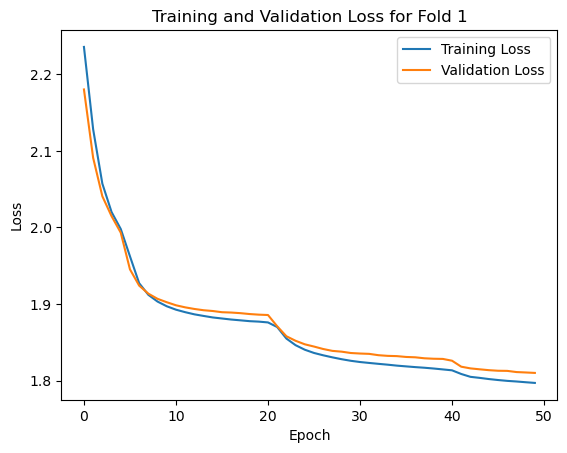

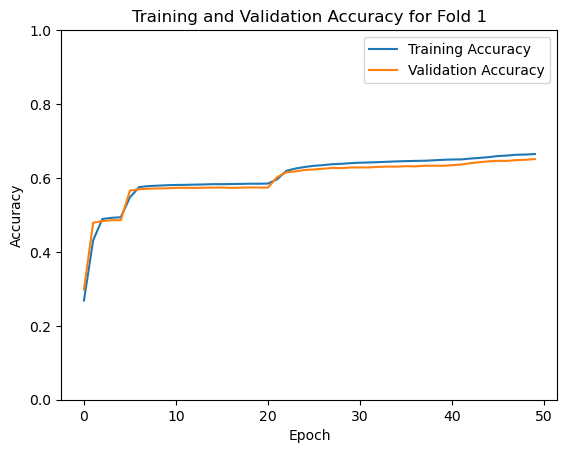

Training size: 40000 	 Validation size: 20000


  2%|▉                                           | 1/50 [00:00<00:19,  2.53it/s]

Epoch 1/50 - Loss: 2.235 - Acc: 0.298
              Val_loss: 2.171 - Val_acc: 0.478


 22%|█████████▍                                 | 11/50 [00:04<00:14,  2.67it/s]

Epoch 11/50 - Loss: 1.818 - Acc: 0.666
              Val_loss: 1.820 - Val_acc: 0.660


 42%|██████████████████                         | 21/50 [00:07<00:11,  2.61it/s]

Epoch 21/50 - Loss: 1.795 - Acc: 0.671
              Val_loss: 1.802 - Val_acc: 0.662


 62%|██████████████████████████▋                | 31/50 [00:11<00:07,  2.63it/s]

Epoch 31/50 - Loss: 1.785 - Acc: 0.681
              Val_loss: 1.794 - Val_acc: 0.669


 82%|███████████████████████████████████▎       | 41/50 [00:15<00:03,  2.60it/s]

Epoch 41/50 - Loss: 1.753 - Acc: 0.714
              Val_loss: 1.760 - Val_acc: 0.705


func:'train'  took: 19.1987 sec
Epoch with lowest validation loss: 50
Epoch with highest validation accuracy: 50


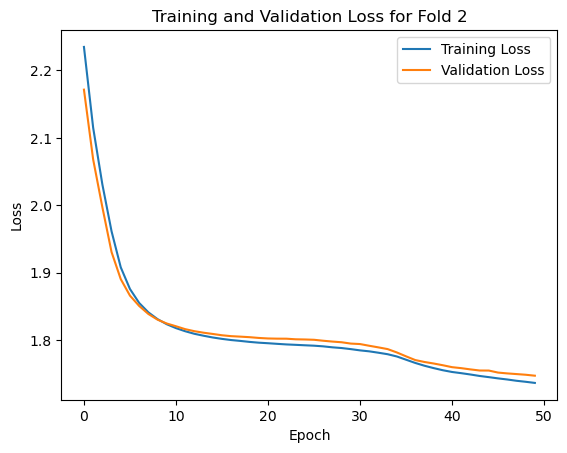

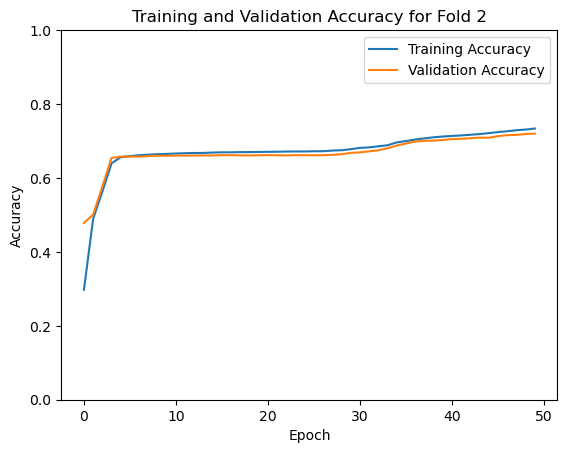

Training size: 40000 	 Validation size: 20000


  2%|▉                                           | 1/50 [00:00<00:18,  2.59it/s]

Epoch 1/50 - Loss: 2.241 - Acc: 0.279
              Val_loss: 2.185 - Val_acc: 0.294


 22%|█████████▍                                 | 11/50 [00:04<00:14,  2.62it/s]

Epoch 11/50 - Loss: 1.889 - Acc: 0.579
              Val_loss: 1.892 - Val_acc: 0.573


 42%|██████████████████                         | 21/50 [00:08<00:11,  2.54it/s]

Epoch 21/50 - Loss: 1.810 - Acc: 0.657
              Val_loss: 1.818 - Val_acc: 0.646


 62%|██████████████████████████▋                | 31/50 [00:12<00:07,  2.54it/s]

Epoch 31/50 - Loss: 1.797 - Acc: 0.668
              Val_loss: 1.811 - Val_acc: 0.652


 82%|███████████████████████████████████▎       | 41/50 [00:15<00:03,  2.54it/s]

Epoch 41/50 - Loss: 1.787 - Acc: 0.679
              Val_loss: 1.802 - Val_acc: 0.660


func:'train'  took: 19.5167 sec
Epoch with lowest validation loss: 50
Epoch with highest validation accuracy: 50


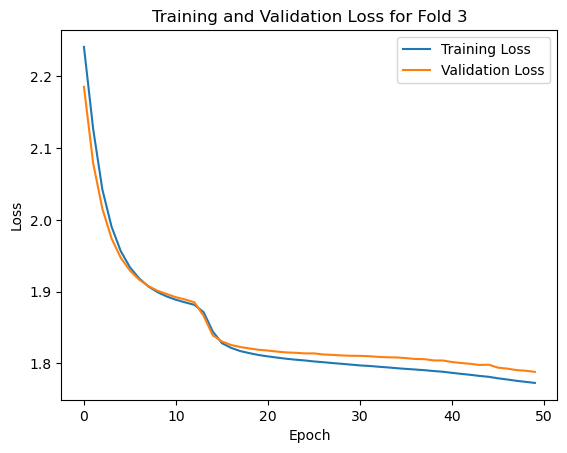

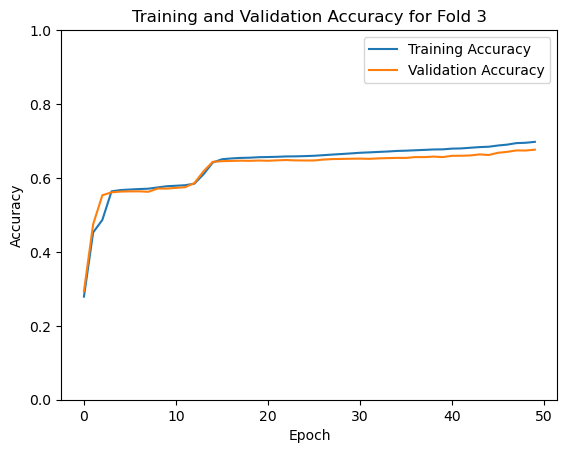

Final Results:
Training accuracy:0.698725+-0.028229
Validation accuracy:0.682500+-0.028396


Training error:1.768720+-0.024892
Validation error:1.781778+-0.026091


In [8]:
Kfold(3, training_data, training_labels)

Here, we see that both training and validation are not very high, both around 68-70%. Loss is also about the same. While accuracy is most often slightly lower and loss slightly higher for the validation data, it does not seem to be super significant. The problem is most likely high bias because the model is slightly lacking in terms of accuracy. However, variance does not seem to be too high and is not much of an issue here.

## (d) ##

Devise another ANN with hidden layer of size 50. Do the same as in (1c). Plot your training and
validation curve, and comment on the bias-variance tradeoff with this choice.

Training size: 40000 	 Validation size: 20000


  2%|▉                                           | 1/50 [00:00<00:25,  1.90it/s]

Epoch 1/50 - Loss: 1.825 - Acc: 0.742
              Val_loss: 1.615 - Val_acc: 0.895


 22%|█████████▍                                 | 11/50 [00:05<00:20,  1.95it/s]

Epoch 11/50 - Loss: 1.503 - Acc: 0.966
              Val_loss: 1.516 - Val_acc: 0.951


 42%|██████████████████                         | 21/50 [00:10<00:14,  1.95it/s]

Epoch 21/50 - Loss: 1.486 - Acc: 0.979
              Val_loss: 1.508 - Val_acc: 0.957


 62%|██████████████████████████▋                | 31/50 [00:15<00:09,  1.95it/s]

Epoch 31/50 - Loss: 1.479 - Acc: 0.985
              Val_loss: 1.505 - Val_acc: 0.959


 82%|███████████████████████████████████▎       | 41/50 [00:21<00:04,  1.91it/s]

Epoch 41/50 - Loss: 1.475 - Acc: 0.988
              Val_loss: 1.503 - Val_acc: 0.960


func:'train'  took: 25.8943 sec
Epoch with lowest validation loss: 49
Epoch with highest validation accuracy: 49


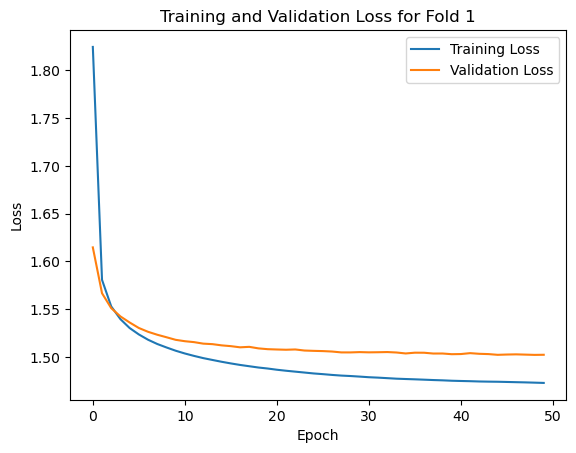

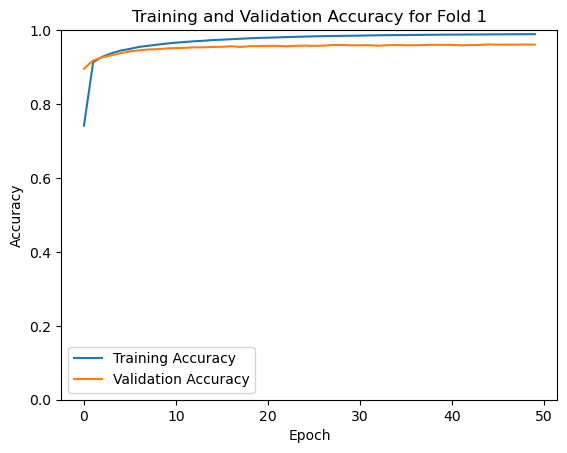

Training size: 40000 	 Validation size: 20000


  2%|▉                                           | 1/50 [00:00<00:26,  1.84it/s]

Epoch 1/50 - Loss: 1.831 - Acc: 0.703
              Val_loss: 1.656 - Val_acc: 0.836


 22%|█████████▍                                 | 11/50 [00:05<00:20,  1.95it/s]

Epoch 11/50 - Loss: 1.503 - Acc: 0.966
              Val_loss: 1.517 - Val_acc: 0.952


 42%|██████████████████                         | 21/50 [00:10<00:14,  1.94it/s]

Epoch 21/50 - Loss: 1.486 - Acc: 0.980
              Val_loss: 1.509 - Val_acc: 0.956


 62%|██████████████████████████▋                | 31/50 [00:16<00:09,  1.92it/s]

Epoch 31/50 - Loss: 1.479 - Acc: 0.985
              Val_loss: 1.505 - Val_acc: 0.960


 82%|███████████████████████████████████▎       | 41/50 [00:21<00:04,  1.94it/s]

Epoch 41/50 - Loss: 1.474 - Acc: 0.988
              Val_loss: 1.504 - Val_acc: 0.959


func:'train'  took: 26.3473 sec
Epoch with lowest validation loss: 50
Epoch with highest validation accuracy: 32


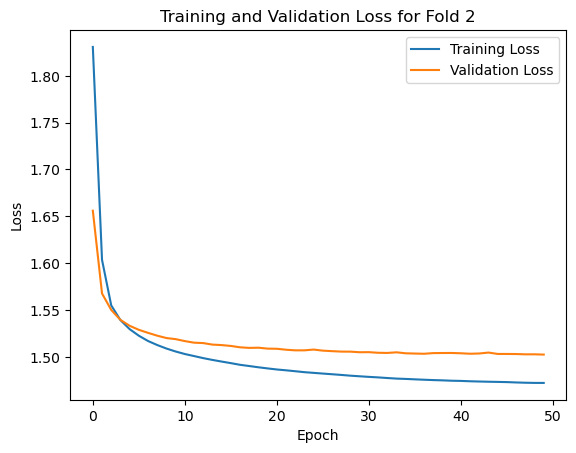

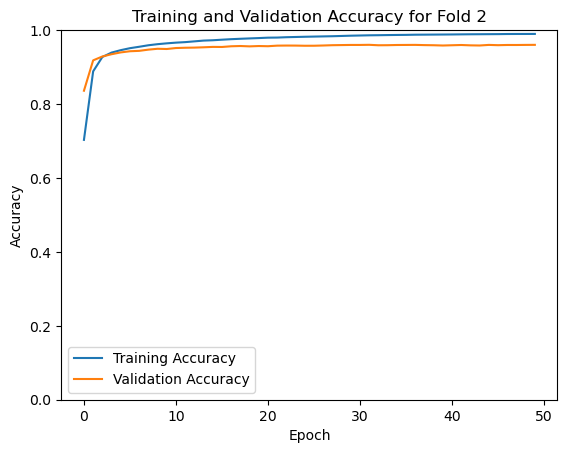

Training size: 40000 	 Validation size: 20000


  2%|▉                                           | 1/50 [00:00<00:27,  1.81it/s]

Epoch 1/50 - Loss: 1.817 - Acc: 0.733
              Val_loss: 1.609 - Val_acc: 0.898


 22%|█████████▍                                 | 11/50 [00:05<00:20,  1.91it/s]

Epoch 11/50 - Loss: 1.504 - Acc: 0.965
              Val_loss: 1.517 - Val_acc: 0.951


 42%|██████████████████                         | 21/50 [00:11<00:14,  1.93it/s]

Epoch 21/50 - Loss: 1.487 - Acc: 0.979
              Val_loss: 1.509 - Val_acc: 0.956


 62%|██████████████████████████▋                | 31/50 [00:16<00:10,  1.83it/s]

Epoch 31/50 - Loss: 1.479 - Acc: 0.986
              Val_loss: 1.505 - Val_acc: 0.959


 82%|███████████████████████████████████▎       | 41/50 [00:21<00:04,  1.95it/s]

Epoch 41/50 - Loss: 1.474 - Acc: 0.989
              Val_loss: 1.504 - Val_acc: 0.959


func:'train'  took: 26.3071 sec
Epoch with lowest validation loss: 47
Epoch with highest validation accuracy: 40


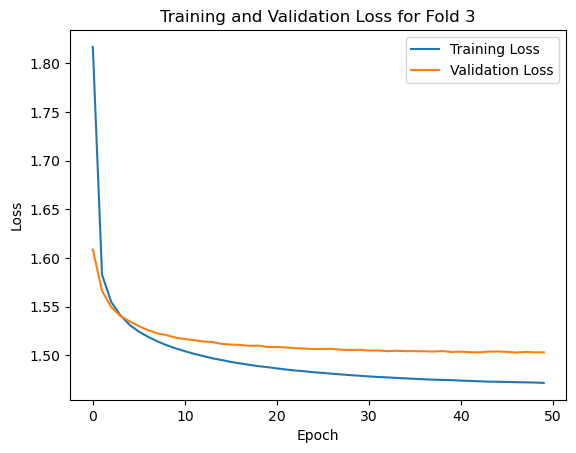

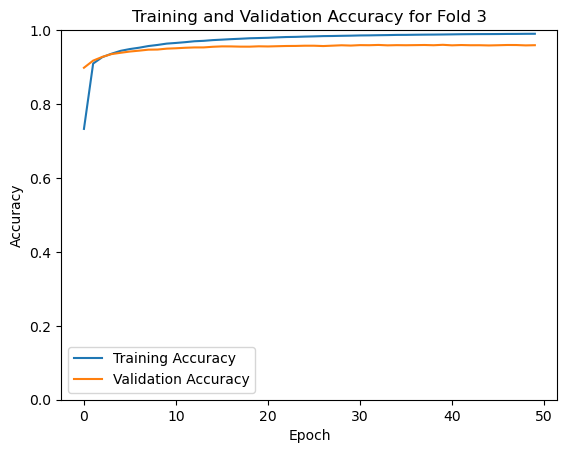

Final Results:
Training accuracy:0.989667+-0.000389
Validation accuracy:0.960050+-0.000657


Training error:1.472213+-0.000333
Validation error:1.502584+-0.000464


In [9]:
Kfold(3, training_data, training_labels, hidden_size=50)

The accuracy has increased significantly to 96-99% for both training and validation, and the error has also decreased compared to when the hidden layer was only size 3. This means has bias has decreased. However, looking at the plots and the statistics, variance is noticeably higher this time. The training data produces noticeably higher accuracies and lower errors compared to the validation data. This could mean that the model is potentially overfit to the training data.

<br>
<br>

## 2. Deep Learning and Regularization

## (a) ##

Using the ANN from 1(d), utilize dropout with 15%. Compare your training and test accuracy to results
in (d).

Training size: 40000 	 Validation size: 20000


  2%|▉                                           | 1/50 [00:00<00:28,  1.74it/s]

Epoch 1/50 - Loss: 1.891 - Acc: 0.636
              Val_loss: 1.628 - Val_acc: 0.888


 22%|█████████▍                                 | 11/50 [00:05<00:21,  1.85it/s]

Epoch 11/50 - Loss: 1.593 - Acc: 0.877
              Val_loss: 1.531 - Val_acc: 0.933


 42%|██████████████████                         | 21/50 [00:11<00:15,  1.86it/s]

Epoch 21/50 - Loss: 1.580 - Acc: 0.884
              Val_loss: 1.522 - Val_acc: 0.940


 62%|██████████████████████████▋                | 31/50 [00:16<00:10,  1.85it/s]

Epoch 31/50 - Loss: 1.572 - Acc: 0.891
              Val_loss: 1.517 - Val_acc: 0.945


 82%|███████████████████████████████████▎       | 41/50 [00:22<00:04,  1.84it/s]

Epoch 41/50 - Loss: 1.567 - Acc: 0.894
              Val_loss: 1.515 - Val_acc: 0.946


func:'train'  took: 27.4179 sec
Epoch with lowest validation loss: 49
Epoch with highest validation accuracy: 49


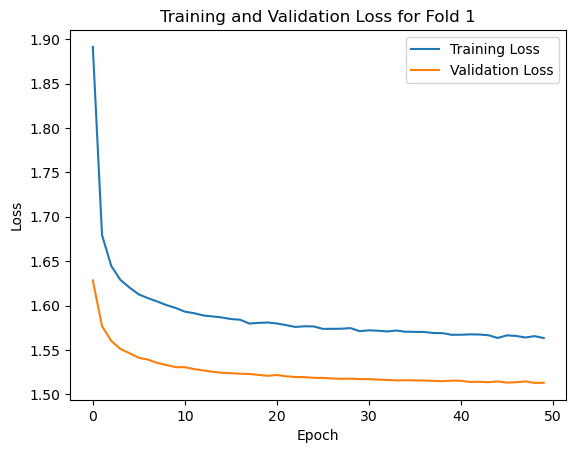

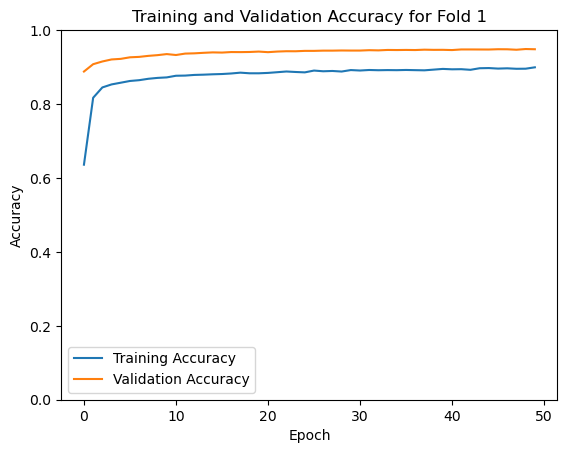

Training size: 40000 	 Validation size: 20000


  2%|▉                                           | 1/50 [00:00<00:27,  1.77it/s]

Epoch 1/50 - Loss: 1.905 - Acc: 0.613
              Val_loss: 1.667 - Val_acc: 0.829


 22%|█████████▍                                 | 11/50 [00:06<00:23,  1.70it/s]

Epoch 11/50 - Loss: 1.594 - Acc: 0.875
              Val_loss: 1.526 - Val_acc: 0.937


 42%|██████████████████                         | 21/50 [00:11<00:15,  1.82it/s]

Epoch 21/50 - Loss: 1.577 - Acc: 0.888
              Val_loss: 1.518 - Val_acc: 0.945


 62%|██████████████████████████▋                | 31/50 [00:17<00:10,  1.74it/s]

Epoch 31/50 - Loss: 1.572 - Acc: 0.890
              Val_loss: 1.514 - Val_acc: 0.948


 82%|███████████████████████████████████▎       | 41/50 [00:23<00:05,  1.67it/s]

Epoch 41/50 - Loss: 1.567 - Acc: 0.894
              Val_loss: 1.512 - Val_acc: 0.949


func:'train'  took: 28.5551 sec
Epoch with lowest validation loss: 47
Epoch with highest validation accuracy: 50


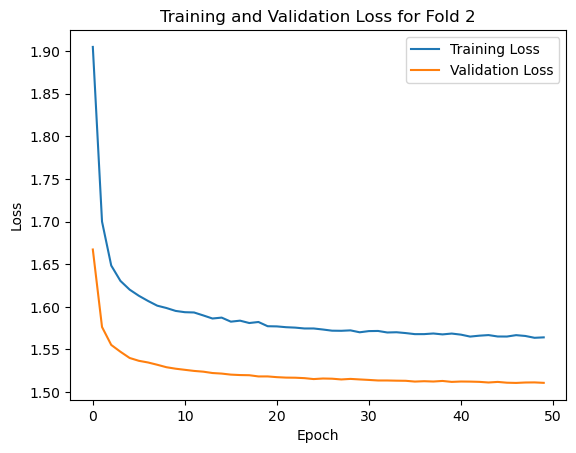

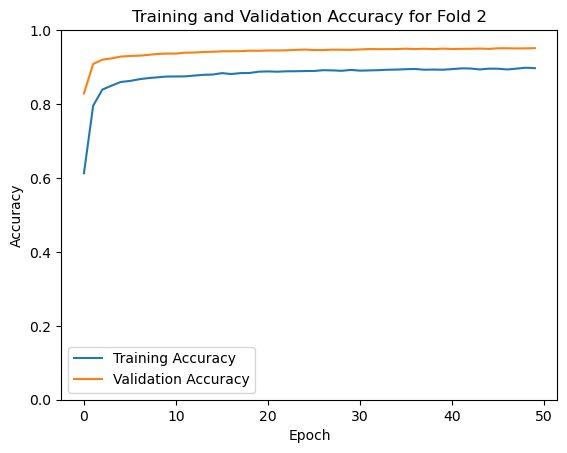

Training size: 40000 	 Validation size: 20000


  2%|▉                                           | 1/50 [00:00<00:26,  1.85it/s]

Epoch 1/50 - Loss: 1.901 - Acc: 0.628
              Val_loss: 1.661 - Val_acc: 0.837


 22%|█████████▍                                 | 11/50 [00:06<00:21,  1.80it/s]

Epoch 11/50 - Loss: 1.593 - Acc: 0.876
              Val_loss: 1.527 - Val_acc: 0.938


 42%|██████████████████                         | 21/50 [00:11<00:16,  1.71it/s]

Epoch 21/50 - Loss: 1.577 - Acc: 0.888
              Val_loss: 1.516 - Val_acc: 0.948


 62%|██████████████████████████▋                | 31/50 [00:17<00:10,  1.80it/s]

Epoch 31/50 - Loss: 1.571 - Acc: 0.891
              Val_loss: 1.513 - Val_acc: 0.950


 82%|███████████████████████████████████▎       | 41/50 [00:23<00:04,  1.80it/s]

Epoch 41/50 - Loss: 1.563 - Acc: 0.899
              Val_loss: 1.511 - Val_acc: 0.951


func:'train'  took: 28.1354 sec
Epoch with lowest validation loss: 50
Epoch with highest validation accuracy: 50


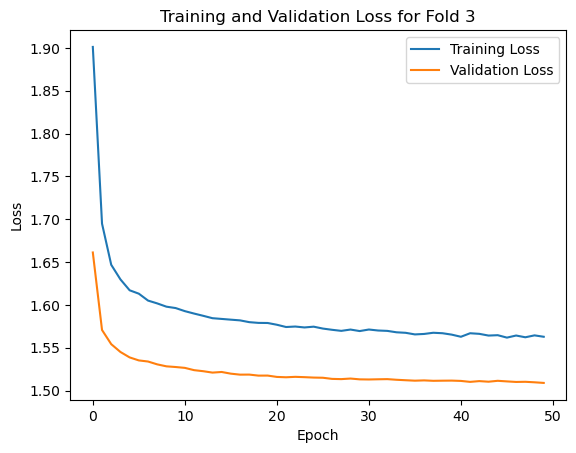

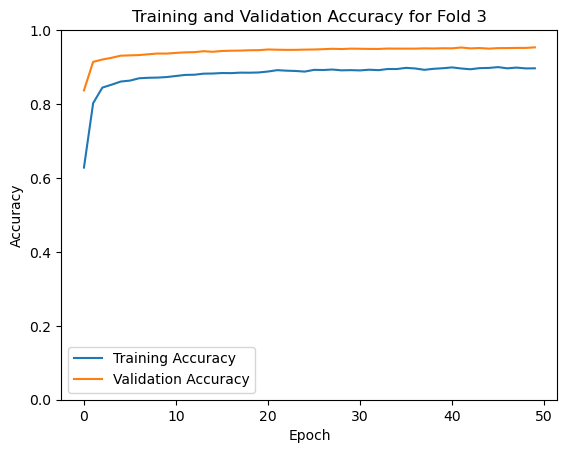

Final Results:
Training accuracy:0.897717+-0.001185
Validation accuracy:0.950950+-0.002093


Training error:1.563487+-0.000571
Validation error:1.510975+-0.001708


In [10]:
Kfold(3, training_data, training_labels, hidden_size=50, dropout=0.15)

These results differ greatly from those of the ANN from 1d. By utilizing dropout with 15%, we see that the model actually performed better on the validation data than on the training data. By utilizing dropout, the model was able to avoid overfitting to the training data and become more generalized. However, this resulted in decreased accuracy of the training data from 0.99 to 0.90. Validation accuracy also decreased slightly from 0.96 to 0.95.

## (b) ##

Using the ANN from 1(d), utilize L2 regularization with lambda=1e-5. How does the result compare to
(d)?

Lambda has been set to 1e-5 in the Trainer class' train method.

Training size: 40000 	 Validation size: 20000


  2%|▉                                           | 1/50 [00:00<00:32,  1.51it/s]

Epoch 1/50 - Loss: 1.842 - Acc: 0.698
              Val_loss: 1.616 - Val_acc: 0.898


 22%|█████████▍                                 | 11/50 [00:08<00:34,  1.13it/s]

Epoch 11/50 - Loss: 1.522 - Acc: 0.964
              Val_loss: 1.517 - Val_acc: 0.953


 42%|██████████████████                         | 21/50 [00:17<00:25,  1.12it/s]

Epoch 21/50 - Loss: 1.510 - Acc: 0.977
              Val_loss: 1.509 - Val_acc: 0.960


 62%|██████████████████████████▋                | 31/50 [00:26<00:17,  1.11it/s]

Epoch 31/50 - Loss: 1.505 - Acc: 0.983
              Val_loss: 1.504 - Val_acc: 0.964


 82%|███████████████████████████████████▎       | 41/50 [00:35<00:08,  1.12it/s]

Epoch 41/50 - Loss: 1.502 - Acc: 0.986
              Val_loss: 1.502 - Val_acc: 0.965


func:'train'  took: 44.0437 sec
Epoch with lowest validation loss: 49
Epoch with highest validation accuracy: 49


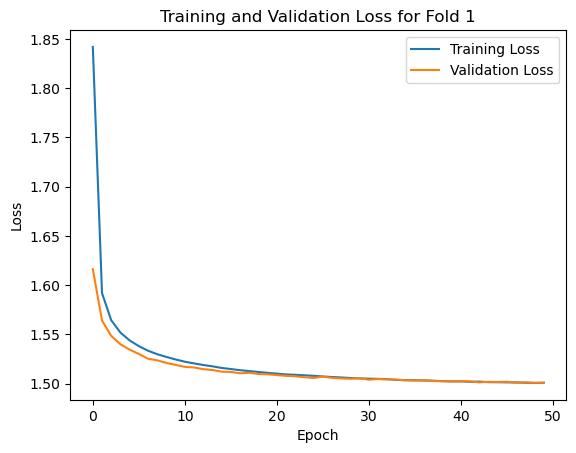

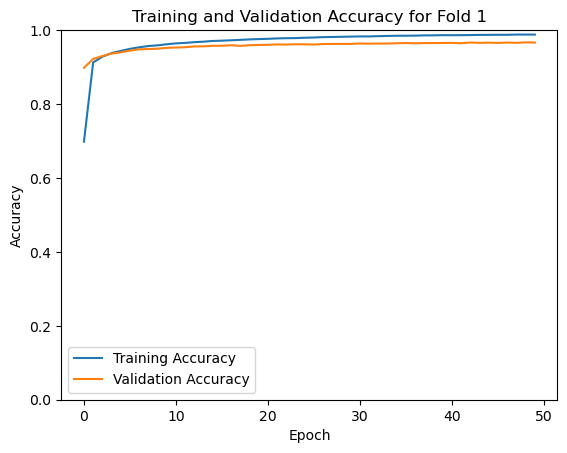

Training size: 40000 	 Validation size: 20000


  2%|▉                                           | 1/50 [00:00<00:33,  1.48it/s]

Epoch 1/50 - Loss: 1.848 - Acc: 0.695
              Val_loss: 1.630 - Val_acc: 0.892


 22%|█████████▍                                 | 11/50 [00:08<00:34,  1.14it/s]

Epoch 11/50 - Loss: 1.523 - Acc: 0.963
              Val_loss: 1.519 - Val_acc: 0.952


 42%|██████████████████                         | 21/50 [00:17<00:25,  1.12it/s]

Epoch 21/50 - Loss: 1.509 - Acc: 0.978
              Val_loss: 1.509 - Val_acc: 0.960


 62%|██████████████████████████▋                | 31/50 [00:27<00:17,  1.10it/s]

Epoch 31/50 - Loss: 1.504 - Acc: 0.985
              Val_loss: 1.504 - Val_acc: 0.964


 82%|███████████████████████████████████▎       | 41/50 [00:36<00:08,  1.12it/s]

Epoch 41/50 - Loss: 1.501 - Acc: 0.988
              Val_loss: 1.502 - Val_acc: 0.966


func:'train'  took: 44.2297 sec
Epoch with lowest validation loss: 44
Epoch with highest validation accuracy: 49


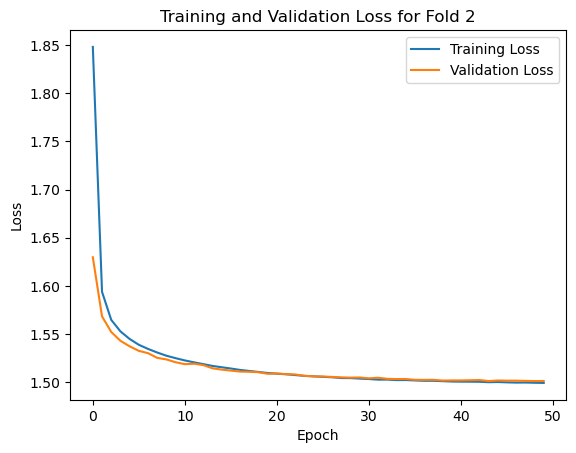

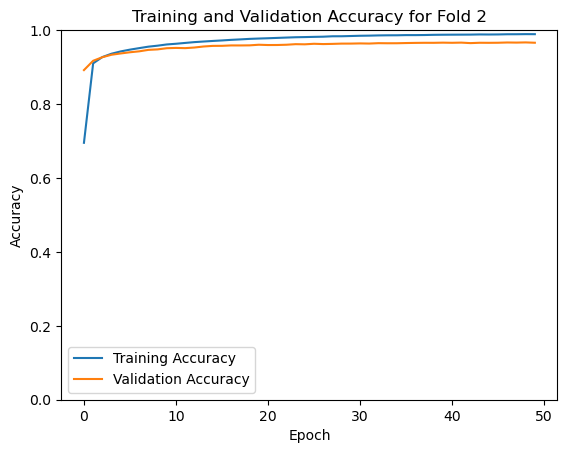

Training size: 40000 	 Validation size: 20000


  2%|▉                                           | 1/50 [00:00<00:31,  1.53it/s]

Epoch 1/50 - Loss: 1.843 - Acc: 0.694
              Val_loss: 1.655 - Val_acc: 0.835


 22%|█████████▍                                 | 11/50 [00:09<00:34,  1.13it/s]

Epoch 11/50 - Loss: 1.523 - Acc: 0.963
              Val_loss: 1.522 - Val_acc: 0.947


 42%|██████████████████                         | 21/50 [00:18<00:25,  1.12it/s]

Epoch 21/50 - Loss: 1.511 - Acc: 0.976
              Val_loss: 1.510 - Val_acc: 0.958


 62%|██████████████████████████▋                | 31/50 [00:27<00:16,  1.12it/s]

Epoch 31/50 - Loss: 1.505 - Acc: 0.982
              Val_loss: 1.505 - Val_acc: 0.963


 82%|███████████████████████████████████▎       | 41/50 [00:36<00:08,  1.11it/s]

Epoch 41/50 - Loss: 1.502 - Acc: 0.986
              Val_loss: 1.502 - Val_acc: 0.965


func:'train'  took: 44.2624 sec
Epoch with lowest validation loss: 47
Epoch with highest validation accuracy: 46


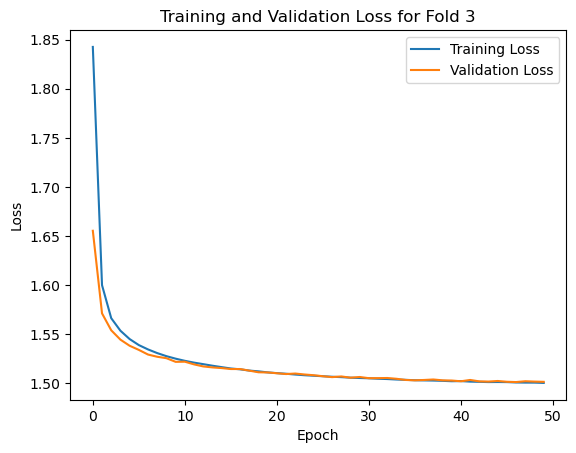

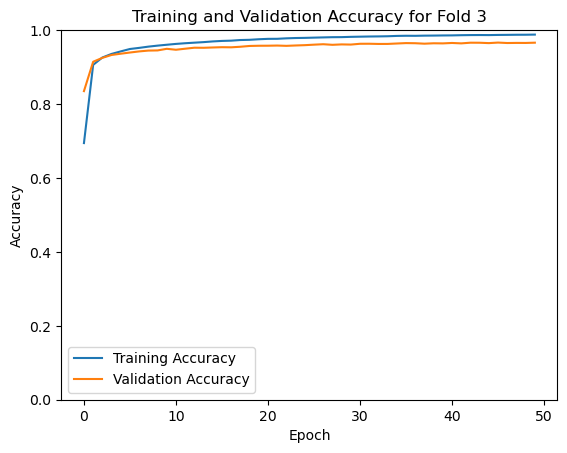

Final Results:
Training accuracy:0.988267+-0.000536
Validation accuracy:0.966067+-0.000209


Training error:1.500292+-0.000585
Validation error:1.501345+-0.000342


In [11]:
Kfold(3, training_data, training_labels, hidden_size=50, l2=True)

The problem of high variance appears to have been alleviated by L2 regularization! Simply looking at the plots, there is less of a difference between the accuracies and errors between training and validation data compared to those from the ANN in 1d. In addition, accuracy and error were not compromised like they were when utilizing dropout. Training accuracy decreased only slightly from 0.988 to 0.987 for training data and increased from 0.960 to 0.966 for validation data. Error is also approximately the same, roughly around 1.5 for all data. This seems to be the best model so far.

## (c) ##

Use principal component analysis on the input, to create a reduced set of input features, keeping 99% of
the variance. This is a type of data transformation! How many parameters do you have in this case and how
does it compare to the original model (i.e. the ANN in 1(d))?

In [12]:
ann_50 = ANN(hidden_size=50)
print("Original model parameters: ", sum([len(item.flatten()) for item in ann_50.parameters()]))

Original model parameters:  51760


In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99)
# reshape training data to 2D
training_data_2D = training_data.reshape(-1, 1024)
pca_train_data = pca.fit_transform(training_data_2D)
pca_train_data.shape

(60000, 331)

Looking at the shape of the new data, we can see that the originally 1024 pixels have been reduced to 331 pixels. We need to update the original ANN class that takes in 1024 pixels to take in 331 pixels.

In [14]:
class ANN_PCA(nn.Module):
    def __init__(self, dropout=0.0, hidden_size=3):
        super(ANN_PCA, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(331, hidden_size),
            nn.Dropout(p=dropout),
            nn.Sigmoid(),
            nn.Linear(hidden_size, 10),
            nn.Dropout(p=dropout),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, x):
        return self.layers(x)
    
ann_pca = ANN_PCA(hidden_size=50)
print("New PCA model parameters: ", sum([len(item.flatten()) for item in ann_pca.parameters()]))

New PCA model parameters:  17110


Comparing the new model to the original model from 1d, keeping the size of the hidden layers at 50, the parameters have been reduced from 51760 to 17110. This is quite a reduction!

## (d) ##

Use the regularization settings (2a or 2b) that give the best result so far, and using the reduced input
space from (c) run the model again. Is the training faster and better this time?

Utilizing L2 regularization with lambda=1e-5 led to higher testing and validation accuracies than utilizing dropout. Now running it with the PCA data transformation...

Training size: 40000 	 Validation size: 20000


  2%|▉                                           | 1/50 [00:00<00:26,  1.87it/s]

Epoch 1/50 - Loss: 1.953 - Acc: 0.588
              Val_loss: 1.738 - Val_acc: 0.750


 22%|█████████▍                                 | 11/50 [00:05<00:20,  1.90it/s]

Epoch 11/50 - Loss: 1.529 - Acc: 0.955
              Val_loss: 1.530 - Val_acc: 0.940


 42%|██████████████████                         | 21/50 [00:11<00:15,  1.91it/s]

Epoch 21/50 - Loss: 1.516 - Acc: 0.971
              Val_loss: 1.518 - Val_acc: 0.949


 62%|██████████████████████████▋                | 31/50 [00:16<00:09,  1.95it/s]

Epoch 31/50 - Loss: 1.510 - Acc: 0.978
              Val_loss: 1.513 - Val_acc: 0.955


 82%|███████████████████████████████████▎       | 41/50 [00:21<00:04,  1.95it/s]

Epoch 41/50 - Loss: 1.507 - Acc: 0.982
              Val_loss: 1.509 - Val_acc: 0.959


func:'train'  took: 26.0982 sec
Epoch with lowest validation loss: 50
Epoch with highest validation accuracy: 48


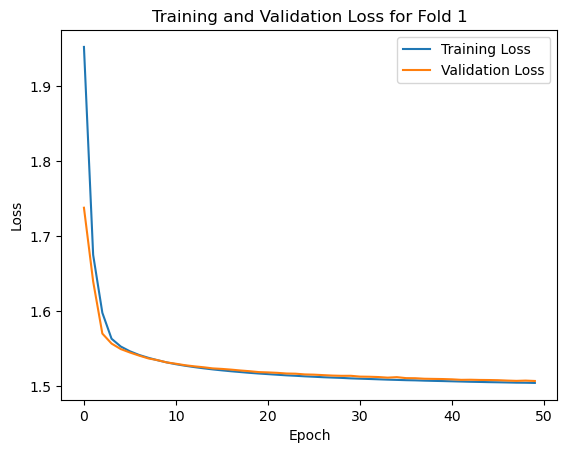

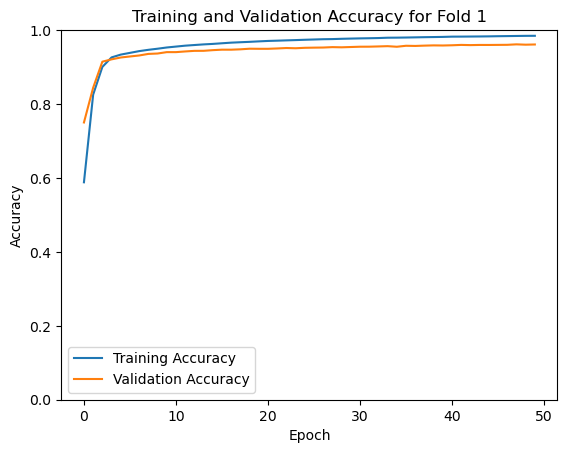

Training size: 40000 	 Validation size: 20000


  2%|▉                                           | 1/50 [00:00<00:27,  1.78it/s]

Epoch 1/50 - Loss: 1.925 - Acc: 0.644
              Val_loss: 1.654 - Val_acc: 0.881


 22%|█████████▍                                 | 11/50 [00:05<00:20,  1.93it/s]

Epoch 11/50 - Loss: 1.529 - Acc: 0.956
              Val_loss: 1.531 - Val_acc: 0.939


 42%|██████████████████                         | 21/50 [00:10<00:14,  1.93it/s]

Epoch 21/50 - Loss: 1.515 - Acc: 0.971
              Val_loss: 1.518 - Val_acc: 0.949


 62%|██████████████████████████▋                | 31/50 [00:16<00:10,  1.89it/s]

Epoch 31/50 - Loss: 1.509 - Acc: 0.979
              Val_loss: 1.513 - Val_acc: 0.953


 82%|███████████████████████████████████▎       | 41/50 [00:21<00:04,  1.94it/s]

Epoch 41/50 - Loss: 1.505 - Acc: 0.983
              Val_loss: 1.511 - Val_acc: 0.957


func:'train'  took: 26.0407 sec
Epoch with lowest validation loss: 50
Epoch with highest validation accuracy: 49


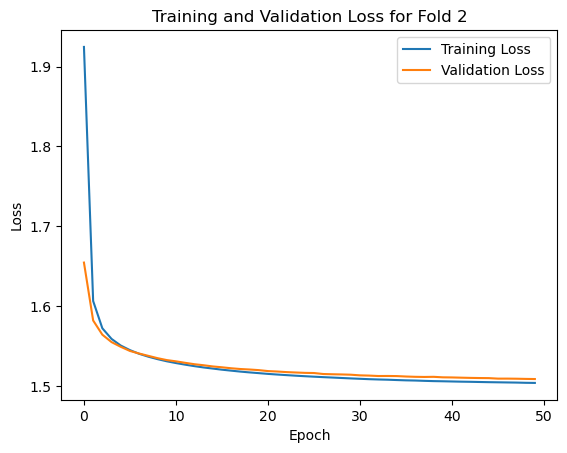

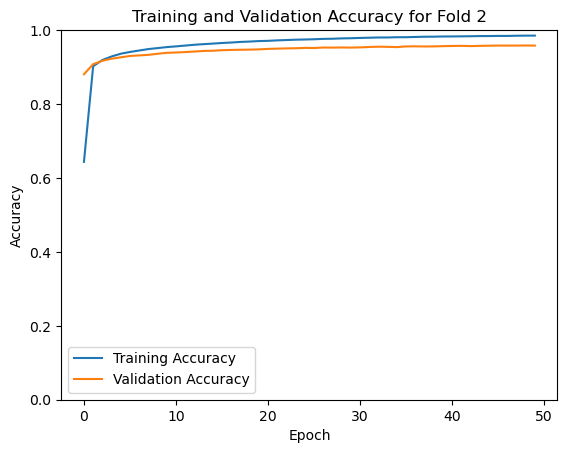

Training size: 40000 	 Validation size: 20000


  2%|▉                                           | 1/50 [00:00<00:25,  1.91it/s]

Epoch 1/50 - Loss: 1.981 - Acc: 0.524
              Val_loss: 1.704 - Val_acc: 0.862


 22%|█████████▍                                 | 11/50 [00:05<00:20,  1.94it/s]

Epoch 11/50 - Loss: 1.529 - Acc: 0.956
              Val_loss: 1.530 - Val_acc: 0.940


 42%|██████████████████                         | 21/50 [00:10<00:14,  1.95it/s]

Epoch 21/50 - Loss: 1.516 - Acc: 0.971
              Val_loss: 1.518 - Val_acc: 0.949


 62%|██████████████████████████▋                | 31/50 [00:16<00:10,  1.85it/s]

Epoch 31/50 - Loss: 1.510 - Acc: 0.978
              Val_loss: 1.514 - Val_acc: 0.952


 82%|███████████████████████████████████▎       | 41/50 [00:21<00:04,  1.95it/s]

Epoch 41/50 - Loss: 1.507 - Acc: 0.982
              Val_loss: 1.511 - Val_acc: 0.955


func:'train'  took: 25.9217 sec
Epoch with lowest validation loss: 50
Epoch with highest validation accuracy: 50


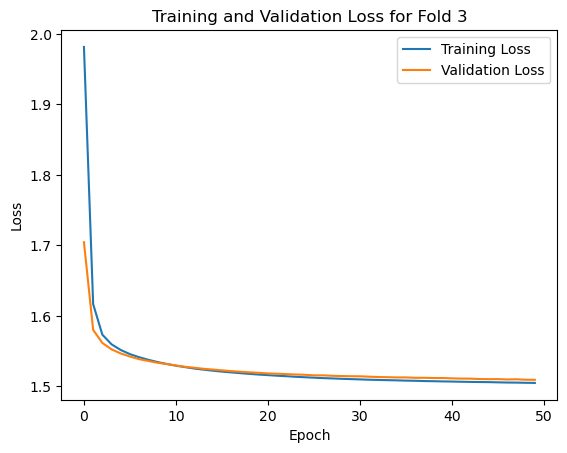

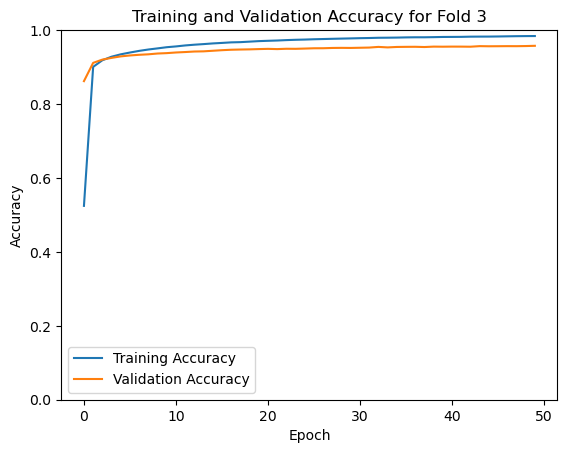

Final Results:
Training accuracy:0.984600+-0.000480
Validation accuracy:0.958950+-0.001575


Training error:1.504349+-0.000513
Validation error:1.508301+-0.000936


In [15]:
Kfold(3, pca_train_data, training_labels, hidden_size=50, l2=True, ann_type='PCA')

The training is significantly faster. Running the train method this time took approximately 26-27 seconds whereas it originally took 45-50 seconds for part 1c. It seems like L2 regularization takes extra computing time compared to other methods, but utilizing PCA cut down on this time. In terms of accuracy and error, this model performed more or less the same as the original, only decreasing very slightly from 0.988 to 0.984 for training data accuracy and 0.966 to 0.958 for validation accuracy. 